In [27]:
import pandas as pd
import numpy as np
import csv
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
from sklearn.linear_model import LinearRegression

In [2]:
p_info = pd.read_csv('participants_data.csv')

In [45]:
summary = pd.DataFrame()
fatigue = pd.DataFrame()
for i, row in p_info.iterrows():
    if row['pid'] in ['P10']:
        continue
    
    fatigue_data = pd.read_csv('result/' + row['pid'] + '_fatigue.csv', index_col=0)
    condition_data = pd.read_csv('result/' + row['pid'] + '_' + row['condition'] + '_training.csv', index_col=0)
    ERD_list = []
    ERD_per_list = []
    for day, block in itertools.product(['Day1', 'Day2', 'Day3'], range(5)):
        if row['condition'] == 'continuous':
            file_index = 'FB'
        else:
            file_index = row['condition']
        filename = 'result/' + row['pid'] + '_' + file_index + '_ERSP_' + day + '_b' + str(block) + '.csv'
        
        if os.path.exists(filename) == False:
            continue
        
        with open(filename, 'r') as f:
            data = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))

        for FB in data:
            ERD_list.append(np.average(FB))
            ERD_per_list.append(sum(i < -10 for i in FB) / len(FB))
    condition_data['ERSP'] = ERD_list
    condition_data['Percent'] = ERD_per_list
    
    summary = pd.concat([summary, condition_data])
    fatigue = pd.concat([fatigue, fatigue_data])

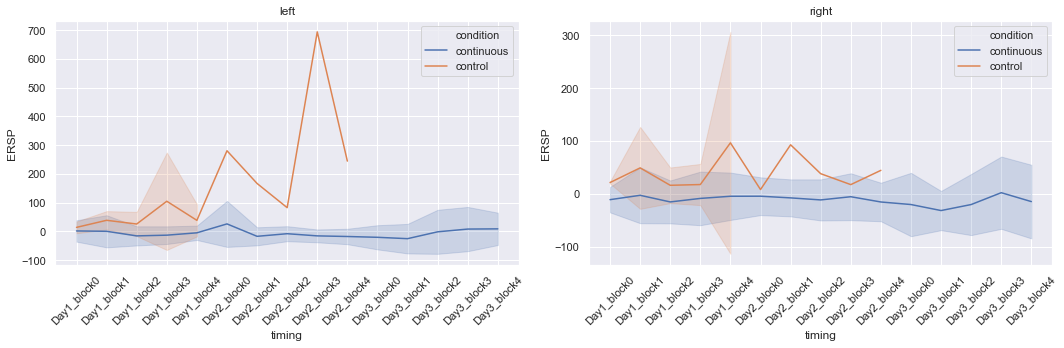

In [46]:
groupby_summary = summary.groupby(['pid', 'condition', 'day', 'block', 'hand'], sort=False, as_index=False).mean()
groupby_summary['timing'] = groupby_summary['day'] + '_block' + [str(n) for n in groupby_summary['block'].values]
plt.figure(figsize=(15,5))
for i, hand in enumerate(['left', 'right']):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x='timing', y='ERSP', hue='condition', ci='sd', data=groupby_summary[groupby_summary.hand == hand])
    plt.title(hand)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ERSP-variation.png')

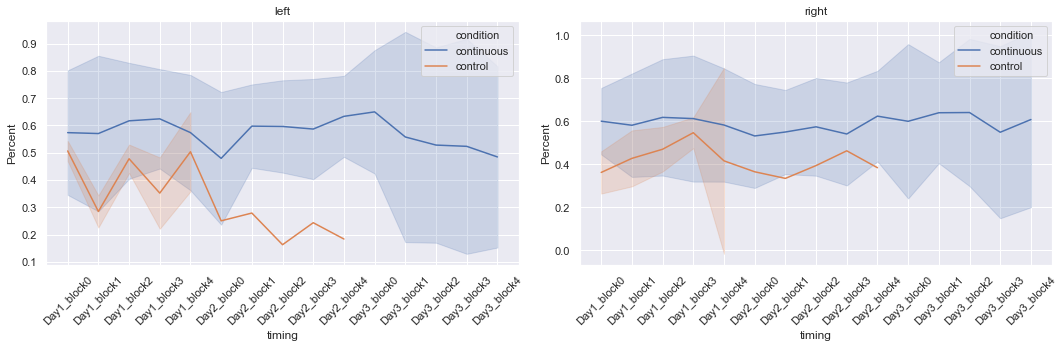

In [47]:
plt.figure(figsize=(15,5))
for i, hand in enumerate(['left', 'right']):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x='timing', y='Percent', hue='condition', ci='sd', data=groupby_summary[groupby_summary.hand == hand])
    plt.title(hand)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ratio-of-ERD.png')

In [48]:
fatigue['Percent'] = summary.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().Percent
fatigue['ERSP'] = summary.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().ERSP

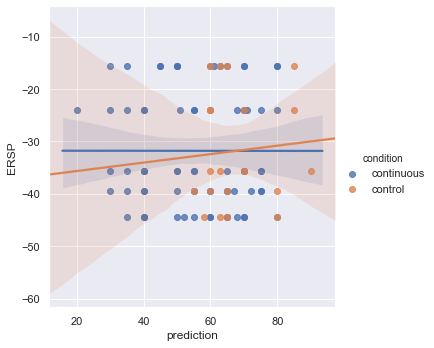

In [49]:
sns.lmplot(x='prediction', y='ERSP', hue='condition', data=fatigue)

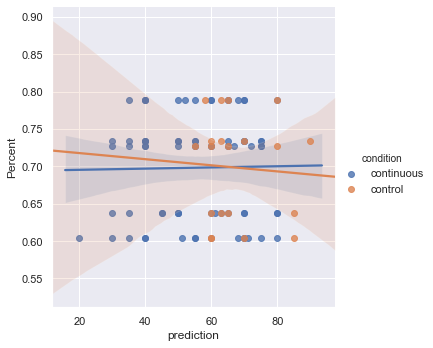

In [50]:
sns.lmplot(x='prediction', y='Percent', hue='condition', data=fatigue)

In [73]:
lr_df = pd.DataFrame(columns=['pid', 'condition', 'day', 'coef', 'intercept', 'R'])
model = LinearRegression()
for pid, day in itertools.product(p_info['pid'], ['Day1', 'Day2', 'Day3']):
    df = fatigue[(fatigue.pid == pid) & (fatigue.day == day)]
    if len(df) == 0:
        continue
    model.fit(df.loc[:, ['Percent']].as_matrix(), df.loc[:, ['prediction']].as_matrix())
    series = pd.Series([pid, p_info[p_info.pid == pid].condition.item(), day, model.coef_, model.intercept_, model.score(df.loc[:, ['ERSP']].as_matrix(), df.loc[:, ['prediction']].as_matrix())], index=lr_df.columns)
    lr_df = lr_df.append(series, ignore_index=True)

c:\users\okamotolab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
c:\users\okamotolab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\okamotolab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
c:\users\okamotolab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\okamotolab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  i

TypeError: unhashable type: 'numpy.ndarray'

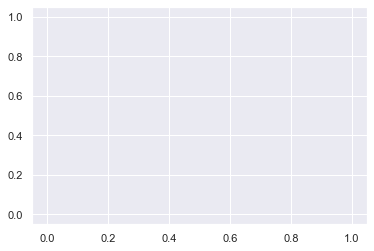

In [75]:
sns.lineplot(x='day', y='coef', hue='condition', data=lr_df)

In [33]:
df.loc[:, ['prediction']].as_matrix()

c:\users\okamotolab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[65],
       [51],
       [70],
       [75],
       [61]], dtype=int64)

In [8]:
pid = 'P07'
condition = p_info[p_info.pid == pid].condition.item()
fatigue_data = pd.read_csv('result/' + pid + '_fatigue.csv', index_col=0)
condition_data = pd.read_csv('result/' + pid + '_' + condition + '_training.csv', index_col=0)
ERD_list = []
ERD_per_list = []
for day, block in itertools.product(['Day1', 'Day2', 'Day3'], range(5)):
    if condition == 'continuous':
        file_index = 'FB'
    else:
        file_index = condition
    filename = 'result/' + pid + '_' + file_index + '_ERSP_' + day + '_b' + str(block) + '.csv'

    if os.path.exists(filename) == False:
        continue

    with open(filename, 'r') as f:
        data = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))

    for FB in data:
        ERD_list.append(np.average(FB))
        ERD_per_list.append(sum(i < -10 for i in FB) / len(FB))
condition_data['ERSP'] = ERD_list
condition_data['Percent'] = ERD_per_list

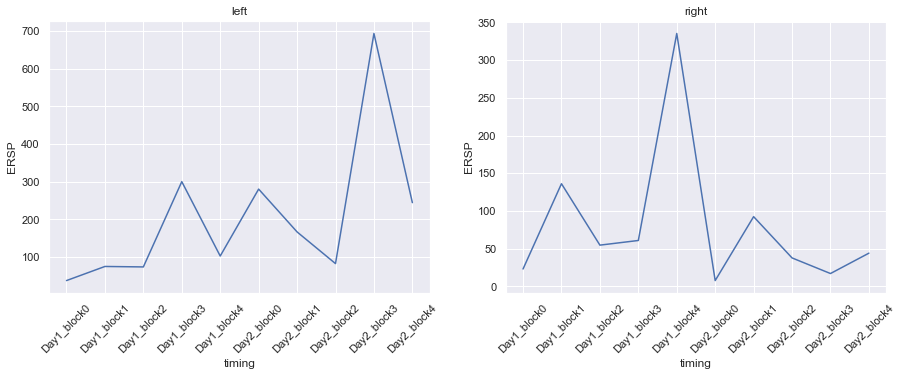

In [9]:
data = condition_data.groupby(['pid', 'condition', 'day', 'block', 'hand'], sort=False, as_index=False).mean()
data['timing'] = data['day'] + '_block' + [str(n) for n in data['block'].values]
plt.figure(figsize=(15,5))
for i, hand in enumerate(['left', 'right']):
    plt.subplot(1, 2, i+1)
    sns.lineplot(x='timing', y='ERSP', data=data[data.hand == hand])
    plt.title(hand)
    plt.xticks(rotation=45)

In [10]:
fatigue_data['Percent'] = condition_data.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().Percent
fatigue_data['ERSP'] = condition_data.groupby(['pid', 'condition', 'day', 'block'], sort=False, as_index=False).mean().ERSP

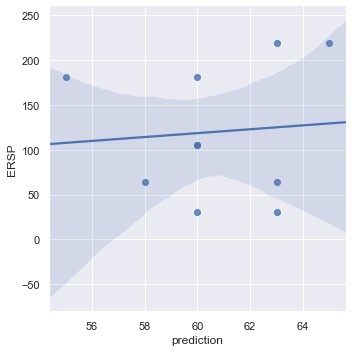

In [11]:
sns.lmplot(x='prediction', y='ERSP', data=fatigue_data)

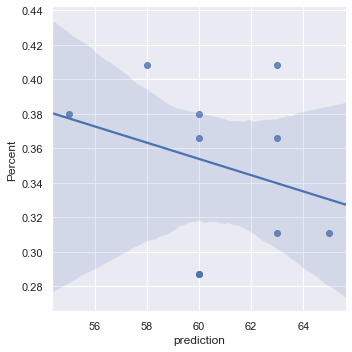

In [12]:
sns.lmplot(x='prediction', y='Percent', data=fatigue_data)